<a href="https://colab.research.google.com/github/manish-anandani/Data-Science-Projects/blob/main/Sentiment_Classification_using_nltk_pyspark_streamlitv1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

Perform sentiment classification by analyzing the tweets data with Pyspark

## Learning Objectives

At the end of the mini-project, you will be able to :

* analyze the text data using pyspark
* derive the insights and visualize the data
* implement feature extraction and classify the data
* train the classification model and deploy

### Dataset

The dataset chosen for this mini-project is **[Twitter US Airline Sentiment](https://data.world/socialmediadata/twitter-us-airline-sentiment)**. It is a record of tweets about airlines in the US. It was created by scraping Twitter data from February 2015. Contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").  Along with other information, it contains ID of a Tweet, the sentiment of a tweet ( neutral, negative and positive), reason for a negative tweet, name of airline and text of a tweet.

## Information

The airline industry is a very competitive market that has grown rapidly in the past 2 decades. Airline companies resort to traditional customer feedback forms which in turn are very tedious and time consuming. This is where Twitter data serves as a good source to gather customer feedback tweets and perform sentiment analysis. This dataset comprises of tweets for 6 major US Airlines and a multi-class classification can be performed to categorize the sentiment (neutral, negative, positive). For this mini-project we will start with pre-processing techniques to clean the tweets and then represent these tweets as vectors. A classification algorithm will be used to predict the sentiment for unseen tweets data. The end-to-end analytics will be performed using Pyspark.

#### Install Pyspark

In [ ]:
#@title Install packages and download the dataset
!pip -qq install pyspark
!pip -qq install handyspark
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/US_Airline_Tweets.csv
print("Packages installed successfully and dataset downloaded!!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Packages installed successfully and dataset downloaded!!


#### Import required packages

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from handyspark import *
import seaborn as sns
from matplotlib import pyplot as plt
import re
import string
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.classification import NaiveBayes
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.types import *
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# NLTK imports
import nltk
nltk.download('punkt')
# Download stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


### Data Loading

#### Start a Spark Session

Spark session is a combined entry point of a Spark application, which came into implementation from Spark 2.0. It provides a way to interact with various Spark functionalities, with a lesser number of constructs.

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

In [ ]:
spark = SparkSession.builder.appName('MP4').config('spark.ui.port', '4050').getOrCreate()
spark

In [ ]:
spark.sparkContext._conf.getAll()

[('spark.app.submitTime', '1707807687490'),
 ('spark.driver.host', 'b805466963dd'),
 ('spark.app.startTime', '1707807687841'),
 ('spark.driver.port', '39525'),
 ('spark.executor.id', 'driver'),
 ('spark.sql.warehouse.dir', 'file:/content/spark-warehouse'),
 ('spark.app.id', 'local-1707807691960'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=j

#### Load the data and infer the schema

To load the dataset use the `read.csv` with `inferSchema` and `header` as parameters.

In [ ]:
path = "/content/US_Airline_Tweets.csv"
df = spark.read.csv(path, header=True, inferSchema=True)

In [ ]:
df.show()

+--------------------+-----------------+----------------------------+--------------+-------------------------+--------------+----------------------+---------------+-------------------+-------------+--------------------+-----------+--------------------+--------------------+--------------------+
|            tweet_id|airline_sentiment|airline_sentiment_confidence|negativereason|negativereason_confidence|       airline|airline_sentiment_gold|           name|negativereason_gold|retweet_count|                text|tweet_coord|       tweet_created|      tweet_location|       user_timezone|
+--------------------+-----------------+----------------------------+--------------+-------------------------+--------------+----------------------+---------------+-------------------+-------------+--------------------+-----------+--------------------+--------------------+--------------------+
|  570306133677760513|          neutral|                         1.0|          NULL|                     NULL|Virgi

### EDA & Visualization

#### Visualize the horizontal barplot of airline_sentiment (positive, negative, neutral)

Convert the data to handyspark and remove the other records from the column except 3 values mentioned above and plot the graph

<Axes: title={'center': 'airline_sentiment'}, xlabel='airline_sentiment'>

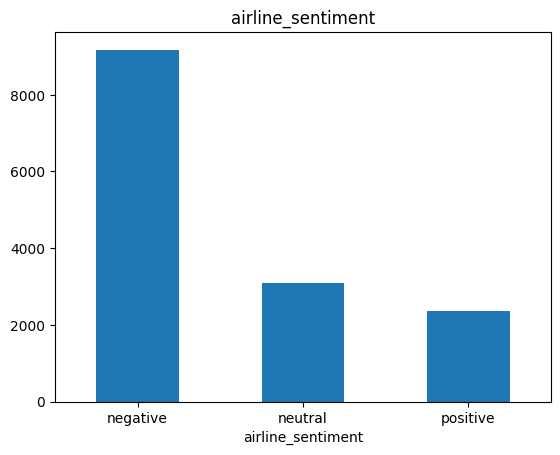

In [ ]:
df_sentiment = df.select("*").where(column("airline_sentiment").isin("positive", "negative", "neutral"))
hdf_sentiment = df_sentiment.toHandy()
hdf_sentiment.cols['airline_sentiment'].hist()


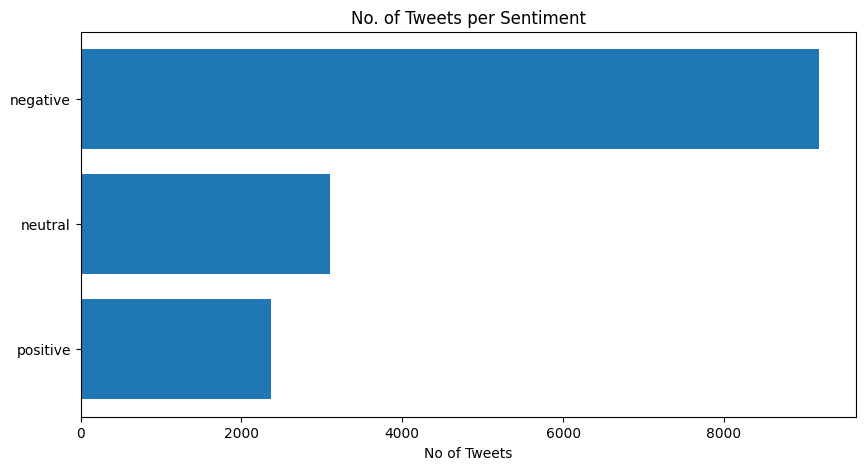

In [ ]:
df_sentiment = df.select("airline_sentiment").where(column("airline_sentiment").isin("positive", "negative", "neutral"))
df_sentiment = df_sentiment.groupby(column('airline_sentiment')).count()
list_sentiments_frequency = df_sentiment.rdd.map(lambda x : (x[0], x[1])).take(10)

keys, values = zip(*list_sentiments_frequency)

plt.figure(figsize=(10,5))
plt.barh(keys, values)
plt.yticks(keys, fontsize=10, rotation=0)
plt.xlabel('No of Tweets', fontsize=10)
plt.title("No. of Tweets per Sentiment")
plt.show()

#### Plot the number of tweets received for each airline

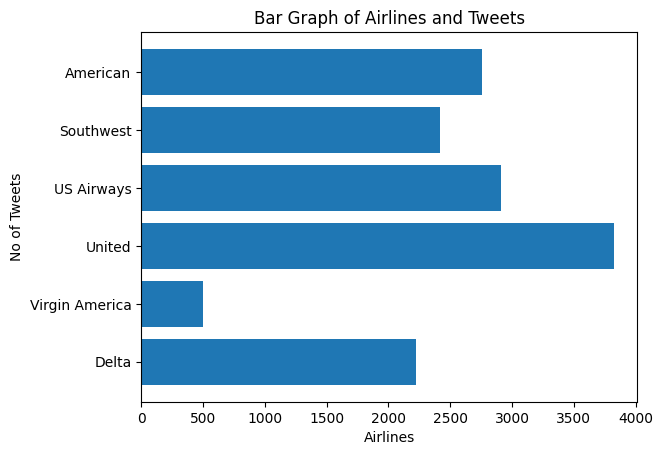

In [ ]:
df_tweets = df.select("*").where(column('airline').isNotNull()).groupby(column('airline')).count()
df_tweets_airlines = df_tweets.where(column('count') > 10)
list_tweets_airlines = df_tweets_airlines.rdd.map(lambda x : (x[0], x[1])).take(10)

keys, values = zip(*list_tweets_airlines)

plt.barh(keys, values)
plt.xlabel("Airlines")
plt.ylabel("No of Tweets")
plt.title("Bar Graph of Airlines and Tweets")
plt.show()

#### Visualize a stacked barchart of 6 US airlines and 3 sentiments on each bar

* Group the sentiment counts for each airline.

* Display the count corresponding to each sentiment in each bar.

In [ ]:
df_airline = df.where(column('airline').isNotNull()).groupby(column('airline')).count().where(column('count') > 10)
airlines = df_airline.rdd.map(lambda x:x[0]).collect()
airlines

['Delta', 'Virgin America', 'United', 'US Airways', 'Southwest', 'American']

In [ ]:
positive = []
negative = []
neutral = []

for airline in airlines:
    print(airline)
    df_airline = df.where(column('airline') == airline).groupby(column('airline_sentiment')).agg(count('airline_sentiment'))
    airline_stats = df_airline.rdd.map(lambda x : (x[0], x[1])).collect()
    positive.append(airline_stats[0][1])
    negative.append(airline_stats[1][1])
    neutral.append(airline_stats[2][1])

positive, negative, neutral

Delta
Virgin America
United
US Airways
Southwest
American


([544, 152, 492, 269, 570, 336],
 [723, 171, 697, 381, 664, 463],
 [955, 181, 2633, 2263, 1186, 1960])

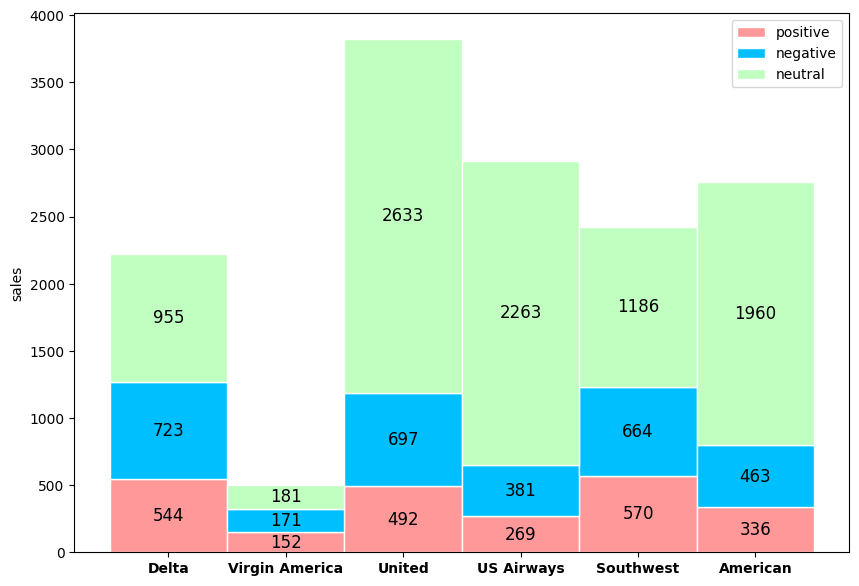

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#Get values from the group and categories
# airlines, positive, negative, neutral
#add colors
colors = ['#FF9999', '#00BFFF','#C1FFC1','#CAE1FF','#FFDEAD']
# The position of the bars on the x-axis
r = range(len(airlines))
barWidth = 1
#plot bars
plt.figure(figsize=(10,7))
ax1 = plt.bar(r, positive, color=colors[0], edgecolor='white', width=barWidth, label="positive")
ax2 = plt.bar(r, negative, bottom=np.array(positive), color=colors[1], edgecolor='white', width=barWidth, label='negative')
ax3 = plt.bar(r, neutral, bottom=np.array(positive)+np.array(negative), color=colors[2], edgecolor='white', width=barWidth, label='neutral')
plt.legend()
# Custom X axis
plt.xticks(r, airlines, fontweight='bold')
plt.ylabel("sales")
# plt.savefig("stacked1.png")

for r1, r2, r3 in zip(ax1, ax2, ax3):
    h1 = r1.get_height()
    h2 = r2.get_height()
    h3 = r3.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1, ha="center", va="center", color="black", fontsize=12)
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2, ha="center", va="center", color="black", fontsize=12)
    plt.text(r3.get_x() + r3.get_width() / 2., h1 + h2 + h3 / 2., "%d" % h3, ha="center", va="center", color="black", fontsize=12)

plt.show()

#### Visualize the horizontal barplot of negative reasons

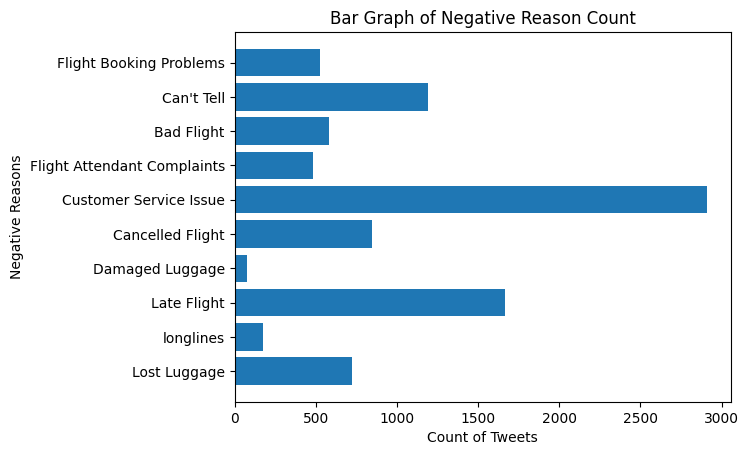

In [ ]:
df_negativereason = df.where(column('negativereason').isNotNull()).groupby(column('negativereason')).count().where(column('count') > 5)

list_negativereasons = df_negativereason.rdd.map(lambda x : (x[0], x[1])).take(20)
keys, values = zip(*list_negativereasons)

plt.barh(keys, values)
plt.xlabel("Count of Tweets")
plt.ylabel("Negative Reasons")
plt.title("Bar Graph of Negative Reason Count")
plt.show()

### Pre-processing

#### Check the null values and drop the records where the text value is null

In [ ]:
# Drop the records where text value is null
df_clean_text = df.where(col('text').isNotNull())
print(df_clean_text.count())


14632


In [ ]:
def display_column_element_counts(df):
    col_names = df.columns
    for name in col_names:
        count = df.filter(~column(name).isNull()).count()
        print(name, count)
    print()

def drop_cols_below_threshold(df, threshold):
    col_names = df.columns
    for name in col_names:
        count = df.filter(~column(name).isNull()).count()
        if (count < threshold):
            print(f"Col dropped: {name}")
            df = df.drop(name)
    return df

# Display dataframe elements in each column
display_column_element_counts(df_clean_text)

# Dropping columns with less than 1100 entries
df_clean_labels = drop_cols_below_threshold(df_clean_text, 1100)

# df_clean = df_clean_labels.drop(cols_to_drop[0], cols_to_drop[1])
df_clean_labels.show(5)

tweet_id 14632
airline_sentiment 14632
airline_sentiment_confidence 14632
negativereason 9170
negativereason_confidence 10514
airline 14632
airline_sentiment_gold 32
name 14632
negativereason_gold 24
retweet_count 14632
text 14632
tweet_coord 1069
tweet_created 14448
tweet_location 9827
user_timezone 9734

Col dropped: airline_sentiment_gold
Col dropped: negativereason_gold
Col dropped: tweet_coord
+------------------+-----------------+----------------------------+--------------+-------------------------+--------------+----------+-------------+--------------------+--------------------+--------------+--------------------+
|          tweet_id|airline_sentiment|airline_sentiment_confidence|negativereason|negativereason_confidence|       airline|      name|retweet_count|                text|       tweet_created|tweet_location|       user_timezone|
+------------------+-----------------+----------------------------+--------------+-------------------------+--------------+----------+----------

#### Fill the null values with 0 in all the columns except the target

The target should not be empty. Ensure that all features are integer type, convert if needed.

In [ ]:
# df_clean_labels.dtypes
numeric_cols = ['airline_sentiment_confidence','negativereason_confidence','retweet_count']
for i in range(len(numeric_cols)):
    df_clean_labels = df_clean_labels.withColumn(numeric_cols[i], col(numeric_cols[i]).cast("float"))

df_clean_labels.dtypes

[('tweet_id', 'string'),
 ('airline_sentiment', 'string'),
 ('airline_sentiment_confidence', 'float'),
 ('negativereason', 'string'),
 ('negativereason_confidence', 'float'),
 ('airline', 'string'),
 ('name', 'string'),
 ('retweet_count', 'float'),
 ('text', 'string'),
 ('tweet_created', 'string'),
 ('tweet_location', 'string'),
 ('user_timezone', 'string')]

In [ ]:
# Replaced NULL values with 0s in numeric columns
df_clean_labels = df_clean_labels.fillna(0, subset=numeric_cols)
display_column_element_counts(df_clean_labels)

non_null_df = df_clean_labels

tweet_id 14632
airline_sentiment 14632
airline_sentiment_confidence 14632
negativereason 9170
negativereason_confidence 14632
airline 14632
name 14632
retweet_count 14632
text 14632
tweet_created 14448
tweet_location 9827
user_timezone 9734



#### Preprocessing and cleaning the tweets

* Convert the text to lower case
* Remove usernames, hashtags and links from the text (tweets)

In [ ]:
non_null_df = non_null_df.withColumn('text_new', lower(col('text')))

username_pattern = r"@\w+"
hashtag_pattern = r"#\w+"
link_pattern = r"http[s]?://\S+"

non_null_df = non_null_df.withColumn('text_new', regexp_replace(col('text_new'), username_pattern, ''))
non_null_df = non_null_df.withColumn('text_new', regexp_replace(col('text_new'), hashtag_pattern, ''))
non_null_df = non_null_df.withColumn('text_new', regexp_replace(col('text_new'), link_pattern, ''))

non_null_df = non_null_df.withColumn('text_new', trim(col('text_new')))

non_null_df.select('*').show(5, truncate=False)

+------------------+-----------------+----------------------------+--------------+-------------------------+--------------+----------+-------------+----------------------------------------------------------------------------------------------------------------------------------+-------------------------+--------------+--------------------------+--------------------------------------------------------------------------------------------------------------------+
|tweet_id          |airline_sentiment|airline_sentiment_confidence|negativereason|negativereason_confidence|airline       |name      |retweet_count|text                                                                                                                              |tweet_created            |tweet_location|user_timezone             |text_new                                                                                                            |
+------------------+-----------------+----------------------------+---

#### Tokenize each sentence into words using nltk word tokenizer

In [ ]:
word_udf = udf(lambda x: word_tokenize(x), ArrayType(StringType()))
non_null_df = non_null_df.withColumn("words", word_udf("text_new"))

In [ ]:
non_null_df.select('*').show(5, truncate=False)

+------------------+-----------------+----------------------------+--------------+-------------------------+--------------+----------+-------------+----------------------------------------------------------------------------------------------------------------------------------+-------------------------+--------------+--------------------------+--------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------+
|tweet_id          |airline_sentiment|airline_sentiment_confidence|negativereason|negativereason_confidence|airline       |name      |retweet_count|text                                                                                                                              |tweet_created            |tweet_location|user_timezone             |text_new                     

#### Remove the stopwords from tokenized words

In [ ]:
stop_words = set(stopwords.words('english'))
print(stop_words)
punctuation = string.punctuation
print(punctuation)

{'itself', 'was', 'o', 'as', 'his', 'down', 'doesn', 'here', 'being', 'until', 'some', 'will', 'after', 'own', 'out', 'did', 'and', 'm', 's', 'again', 'only', 'at', 'there', 'll', 'all', 'my', 'are', 'below', 'me', 'this', 'for', 'doing', 'does', 'so', 'herself', 'then', 'not', 'needn', 'who', 'didn', 'yours', 'the', "she's", 'him', 'd', "won't", 'once', 'hers', 'an', "you'd", 'same', 'wouldn', 'ours', "mightn't", 'each', 'or', "shan't", 'has', "weren't", 'before', "mustn't", "should've", "couldn't", 'wasn', 'just', 'about', "you've", 'should', 'both', "didn't", 'haven', 'theirs', 'between', 'above', 'what', 'through', 'couldn', 'i', 'up', 'few', 'during', 'to', 'too', "wasn't", 'their', 'but', 'by', 'mightn', 'have', 'under', 'while', 'yourselves', 'won', 'if', 'myself', 'over', 'those', 'am', "don't", 'your', 're', 'further', 'whom', 'weren', 'we', 'shouldn', 'yourself', 'than', 'ain', "hasn't", 'such', "aren't", "that'll", 'more', 'them', 'were', 'no', 'which', 'very', 'why', 'had',

In [ ]:
punct_udf = udf(lambda x: [w for w in x if not w.lower() in punctuation if not w.lower() in stop_words])
non_null_df = non_null_df.withColumn("words", punct_udf("words"))
non_null_df.show(5,truncate= False)

+------------------+-----------------+----------------------------+--------------+-------------------------+--------------+----------+-------------+----------------------------------------------------------------------------------------------------------------------------------+-------------------------+--------------+--------------------------+--------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------+
|tweet_id          |airline_sentiment|airline_sentiment_confidence|negativereason|negativereason_confidence|airline       |name      |retweet_count|text                                                                                                                              |tweet_created            |tweet_location|user_timezone             |text_new                                                            

#### Apply Lemmatization to the words

In [ ]:
non_null_df.show()

+------------------+-----------------+----------------------------+--------------+-------------------------+--------------+---------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|          tweet_id|airline_sentiment|airline_sentiment_confidence|negativereason|negativereason_confidence|       airline|           name|retweet_count|                text|       tweet_created|      tweet_location|       user_timezone|            text_new|               words|
+------------------+-----------------+----------------------------+--------------+-------------------------+--------------+---------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|570306133677760513|          neutral|                         1.0|          NULL|                      0.0|Virgin America|        cairdin|          0.0|@Virgin

In [ ]:
# Define a UDF for lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize_list(word_list):
    return [lemmatizer.lemmatize(word) for word in word_list]

lemmatize_udf = udf(lemmatize_list, ArrayType(StringType()))

non_null_df = non_null_df.withColumn("lemmatized_words", lemmatize_udf(col("words")))
non_null_df.select('lemmatized_words').show(4, truncate=False)


+---------------------------------------------------------------------------------------------------------------------+
|lemmatized_words                                                                                                     |
+---------------------------------------------------------------------------------------------------------------------+
|[said]                                                                                                               |
|[plus, 've, added, commercial, experience, ..., tacky]                                                               |
|[n't, today, ..., must, mean, need, take, another, trip]                                                             |
|[``, 's, really, aggressive, blast, obnoxious, ``, '', entertainment, '', '', guest, face, amp, little, recourse, '']|
+---------------------------------------------------------------------------------------------------------------------+
only showing top 4 rows



In [ ]:
# TBD apply Stemming

### Feature Extraction

Create the useful features from the text column to train the model

For example:
* Length of the tweet
* No. of hashtags in the tweet starting with '#'
* No. of mentions in the tweet starting with '@'

Hint: create a new column for each of the above features

In [ ]:
len_udf = udf(lambda x: len(x), IntegerType())
non_null_df = non_null_df.withColumn("no_of_words", len_udf("words"))


def count_hashtags(tweet):
    # Split the tweet by spaces
    words = tweet.split()

    # Count hashtags that start with '#'
    hashtag_count = 0
    for word in words:
        if word.startswith('#'):
            hashtag_count += 1

    return hashtag_count
hashtagcount_udf = udf(count_hashtags, IntegerType())

def count_mentions(tweet):
    # Split the tweet by spaces
    words = tweet.split()

    # Count hashtags that start with '#'
    mention_count = 0
    for word in words:
        if word.startswith('@'):
            mention_count += 1

    return mention_count
mentionscount_udf = udf(count_mentions, IntegerType())

non_null_df = non_null_df.withColumn("no_of_hashtags", hashtagcount_udf(col("text")))
non_null_df = non_null_df.withColumn("no_of_mentions", mentionscount_udf(col("text")))

non_null_df.printSchema()

root
 |-- tweet_id: string (nullable = true)
 |-- airline_sentiment: string (nullable = true)
 |-- airline_sentiment_confidence: float (nullable = false)
 |-- negativereason: string (nullable = true)
 |-- negativereason_confidence: float (nullable = false)
 |-- airline: string (nullable = true)
 |-- name: string (nullable = true)
 |-- retweet_count: float (nullable = false)
 |-- text: string (nullable = true)
 |-- tweet_created: string (nullable = true)
 |-- tweet_location: string (nullable = true)
 |-- user_timezone: string (nullable = true)
 |-- text_new: string (nullable = true)
 |-- words: string (nullable = true)
 |-- lemmatized_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- no_of_words: integer (nullable = true)
 |-- no_of_hashtags: integer (nullable = true)
 |-- no_of_mentions: integer (nullable = true)



In [ ]:
non_null_df.show()

+------------------+-----------------+----------------------------+--------------+-------------------------+--------------+---------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------+--------------+
|          tweet_id|airline_sentiment|airline_sentiment_confidence|negativereason|negativereason_confidence|       airline|           name|retweet_count|                text|       tweet_created|      tweet_location|       user_timezone|            text_new|               words|    lemmatized_words|no_of_words|no_of_hashtags|no_of_mentions|
+------------------+-----------------+----------------------------+--------------+-------------------------+--------------+---------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+--

#### Get the features by applying CountVectorizer
CountVectorizer converts the list of tokens to vectors of token counts. See the [documentation](https://spark.apache.org/docs/latest/ml-features.html#countvectorizer) for details.

In [ ]:
# fit a CountVectorizerModel from the corpus.
cv = CountVectorizer(inputCol="lemmatized_words", outputCol="lemmatized_words_vector")

model_cv = cv.fit(non_null_df)

non_null_df = model_cv.transform(non_null_df)
non_null_df.show(3, truncate=False)

+------------------+-----------------+----------------------------+--------------+-------------------------+--------------+----------+-------------+------------------------------------------------------------------------+-------------------------+--------------+--------------------------+---------------------------------------------------------+--------------------------------------------------------+--------------------------------------------------------+-----------+--------------+--------------+----------------------------------------------------------------------------+
|tweet_id          |airline_sentiment|airline_sentiment_confidence|negativereason|negativereason_confidence|airline       |name      |retweet_count|text                                                                    |tweet_created            |tweet_location|user_timezone             |text_new                                                 |words                                                   |lemmatized_word

#### Encode the labels

Using the `udf` function encode the string values of *airline_sentiment* to integers.

In [ ]:
def LabelEncoder(x):
    if x == 'positive':
        return 0
    elif x == 'negative':
        return 1
    return 2

labelEncoder_udf = udf(LabelEncoder, IntegerType())

non_null_df = non_null_df.withColumn("Encoded_label", labelEncoder_udf(col("airline_sentiment")))


In [ ]:
non_null_df.groupby(col('airline_sentiment')).count().show()

+-----------------+-----+
|airline_sentiment|count|
+-----------------+-----+
|         positive| 2363|
|          neutral| 3099|
|         negative| 9170|
+-----------------+-----+



### Train the classifier the evaluate

#### Create vector assembler with the selected features to train the model

In [ ]:
# Feature selection
non_null_df.show(10, truncate=False)

+------------------+-----------------+----------------------------+--------------+-------------------------+--------------+----------+-------------+----------------------------------------------------------------------------------------------------------------------------------+-------------------------+----------------+--------------------------+--------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------+-----------+--------------+--------------+--------------------------------------------------------------------------------------------------------------------+-------------+
|tweet_id          |airline_sentiment|airline_sentiment_confidence|negativereason|negativereason_confidence|airline       

In [ ]:
# df_features = non_null_df.select('airline_sentiment_confidence','negativereason_confidence','retweet_count','no_of_words','no_of_hashtags','no_of_mentions','lemmatized_words_vector','Encoded_label')
df_features = non_null_df.select('no_of_words','no_of_hashtags','no_of_mentions','lemmatized_words_vector','Encoded_label')
df_features.show(10)

+-----------+--------------+--------------+-----------------------+-------------+
|no_of_words|no_of_hashtags|no_of_mentions|lemmatized_words_vector|Encoded_label|
+-----------+--------------+--------------+-----------------------+-------------+
|          1|             0|             2|    (12444,[132],[1.0])|            2|
|          7|             0|             1|   (12444,[13,37,113...|            0|
|          9|             0|             1|   (12444,[1,13,20,4...|            2|
|         17|             0|             0|   (12444,[2,3,10,18...|            1|
|          5|             0|             1|   (12444,[3,70,127,...|            1|
|          8|             0|             1|   (12444,[0,1,22,35...|            1|
|         13|             0|             1|   (12444,[11,46,56,...|            0|
|          8|             0|             1|   (12444,[70,187,23...|            2|
|          3|             0|             1|   (12444,[143,5767,...|            0|
|          6|   

#### Arrange features and label and split them into train and test.

In [ ]:
# assembler = VectorAssembler(inputCols= ['airline_sentiment_confidence','negativereason_confidence','retweet_count','no_of_words','no_of_hashtags','no_of_mentions','lemmatized_words_vector'], outputCol= "features")
assembler = VectorAssembler(inputCols= ['no_of_words','no_of_hashtags','no_of_mentions','lemmatized_words_vector'], outputCol= "features")
output = assembler.transform(df_features)
output.show(10, truncate=False)


+-----------+--------------+--------------+--------------------------------------------------------------------------------------------------------------------+-------------+----------------------------------------------------------------------------------------------------------------------------------+
|no_of_words|no_of_hashtags|no_of_mentions|lemmatized_words_vector                                                                                             |Encoded_label|features                                                                                                                          |
+-----------+--------------+--------------+--------------------------------------------------------------------------------------------------------------------+-------------+----------------------------------------------------------------------------------------------------------------------------------+
|1          |0             |2             |(12444,[132],[1.0])                    

In [ ]:
final_data = output.select("features",'Encoded_label')
train_data,test_data = final_data.randomSplit([0.7,0.3])

#### Train the model with train data and make predictions on the test data

For classification of text data, implement NaiveBayes classifier. It is a probabilistic machine learning model.

For more information about **NaiveBayes Classifier**, click [here](https://spark.apache.org/docs/latest/ml-classification-regression.html#naive-bayes)

In [ ]:
nb = NaiveBayes(featuresCol='features', labelCol='Encoded_label',modelType="multinomial",smoothing=1.0)
# Fit the model with train data
model_nb = nb.fit(train_data)

In [ ]:
# get the predictions
predictions = model_nb.transform(test_data)
predictions.where(col('Encoded_label') != 1).show(10)

+--------------------+-------------+--------------------+--------------------+----------+
|            features|Encoded_label|       rawPrediction|         probability|prediction|
+--------------------+-------------+--------------------+--------------------+----------+
|(12447,[0,1,2,3,4...|            0|[-160.03911495163...|[0.63763608916418...|       0.0|
|(12447,[0,1,2,3,4...|            0|[-103.91682428764...|[0.00247118143751...|       1.0|
|(12447,[0,1,2,3,4...|            0|[-108.57287856179...|[0.00338480811501...|       1.0|
|(12447,[0,1,2,3,5...|            2|[-121.62171677679...|[3.54707429580076...|       1.0|
|(12447,[0,1,2,3,6...|            0|[-128.90336115641...|[0.50573448281644...|       0.0|
|(12447,[0,1,2,3,7...|            2|[-82.269195696998...|[3.36559490806586...|       1.0|
|(12447,[0,1,2,3,7...|            2|[-41.650915633811...|[0.02496086423762...|       1.0|
|(12447,[0,1,2,3,9...|            0|[-72.761546267003...|[0.81095625591651...|       0.0|
|(12447,[0

#### Evaluate the model and find the accuracy

Compare the labels and predictions and find how many are correct.

To find the accuracy, get the count of correct predictions from test data and divide by the total amount of test dataset.

**Hint:** convert the predictions dataframe to pandas and compare with labels

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="Encoded_label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Model accuracy: {accuracy:.4f}")

Model accuracy: 0.7631


Some Random experiments

In [ ]:
# test_data.show(5)
test_data_pred = test_data.where(col('Encoded_label') == 2)
test_data_pred = spark.createDataFrame(test_data_pred.head(1))
test_data_pred = test_data_pred.select('features')
test_data_pred.show(truncate=False)

+-------------------------------------------------------------------------------------------------+
|features                                                                                         |
+-------------------------------------------------------------------------------------------------+
|(12447,[0,1,2,3,5,13,49,193,228,338,490,6675],[13.0,2.0,1.0,1.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0])|
+-------------------------------------------------------------------------------------------------+



In [ ]:
pred_features = predictions.select('features').where(col('prediction') == 2.0)
test_data_pred = spark.createDataFrame(pred_features.head(1))
test_data_pred = test_data_pred.select('features')
test_data_pred.show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                           |
+-----------------------------------------------------------------------------------------------------------------------------------+
|(12447,[0,1,2,3,6,21,39,131,171,265,268,627,851,1519,2158,6813],[13.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
+-----------------------------------------------------------------------------------------------------------------------------------+



In [ ]:
predictions = model_nb.transform(test_data_pred)
predictions.show()

+--------------------+--------------------+--------------------+----------+
|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|(12447,[0,1,2,3,6...|[-132.37556516686...|[3.52905991049599...|       2.0|
+--------------------+--------------------+--------------------+----------+



### Deployment

Let's integrate all the above code snippets in app.py and run it with **Streamlit**.

From the start (data loading step), place every code in app.py including data preprocessing, feature extraction and model training.

* implement the `predict_users_Input()` function which takes one tweet input from user and returns the prediction using the trained model.

* use the same preprocessing techniques and features extraction used for train data on user input.

* user input can be captured from the textbox from **Streamlit** app. Action is triggered when predict button is clicked and user input is classified using `predict_users_Input()` function.


For More information about Streamlit, click [here](https://docs.streamlit.io/en/stable/)

In [ ]:
# Install streamlit and colab-everything
!pip install -qq streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.3 MB/s eta 0:00:00


Create the `app.py` file and run with Streamlit

**Note:** We have provided the required code to execute Streamlit.

In [ ]:
%%writefile app.py
import streamlit as st
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import re
import string
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.classification import NaiveBayes
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.types import *
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

st.write("Run 3 - 14.26")

st.write("Creating a spark session")
spark = SparkSession.builder.appName('TwitterSentiment').getOrCreate()
df = spark.read.csv("/content/US_Airline_Tweets.csv",inferSchema=True,header=True)

st.write("Preprocessing the train data")
# 1. Data preprocessing (PASTE YOUR ENTIRE DATA PREPROCESSING CODE FROM ABOVE)
df_clean_text = df.where(col('text').isNotNull())
def drop_cols_below_threshold(df, threshold):
    col_names = df.columns
    for name in col_names:
        count = df.filter(~column(name).isNull()).count()
        if (count < threshold):
            print(f"Col dropped: {name}")
            df = df.drop(name)
    return df
# Dropping columns with less than 1100 entries
df_clean_labels = drop_cols_below_threshold(df_clean_text, 1100)
numeric_cols = ['airline_sentiment_confidence','negativereason_confidence','retweet_count']
for i in range(len(numeric_cols)):
    df_clean_labels = df_clean_labels.withColumn(numeric_cols[i], col(numeric_cols[i]).cast("float"))
df_clean_labels = df_clean_labels.fillna(0, subset=numeric_cols)
non_null_df = df_clean_labels
non_null_df = non_null_df.withColumn('text_new', lower(col('text')))

username_pattern = r"@\w+"
hashtag_pattern = r"#\w+"
link_pattern = r"http[s]?://\S+"

non_null_df = non_null_df.withColumn('text_new', regexp_replace(col('text_new'), username_pattern, ''))
non_null_df = non_null_df.withColumn('text_new', regexp_replace(col('text_new'), hashtag_pattern, ''))
non_null_df = non_null_df.withColumn('text_new', regexp_replace(col('text_new'), link_pattern, ''))

non_null_df = non_null_df.withColumn('text_new', trim(col('text_new')))

word_udf = udf(lambda x: word_tokenize(x), ArrayType(StringType()))
non_null_df = non_null_df.withColumn("words", word_udf("text_new"))

stop_words = set(stopwords.words('english'))
punctuation = string.punctuation
punct_udf = udf(lambda x: [w for w in x if not w.lower() in punctuation if not w.lower() in stop_words])
non_null_df = non_null_df.withColumn("words", punct_udf("words"))

lemmatizer = WordNetLemmatizer()
def lemmatize_list(word_list):
    return [lemmatizer.lemmatize(word) for word in word_list]
lemmatize_udf = udf(lemmatize_list, ArrayType(StringType()))
non_null_df = non_null_df.withColumn("lemmatized_words", lemmatize_udf(col("words")))


st.write("Ongoing feature extraction!!")
# 2. Feature Extraction (PASTE YOUR ENTIRE FEATURE EXTRACTION CODE FROM ABOVE)

len_udf = udf(lambda x: len(x), IntegerType())
non_null_df = non_null_df.withColumn("no_of_words", len_udf("words"))

def count_hashtags(tweet):
    # Split the tweet by spaces
    words = tweet.split()

    # Count hashtags that start with '#'
    hashtag_count = 0
    for word in words:
        if word.startswith('#'):
            hashtag_count += 1

    return hashtag_count
hashtagcount_udf = udf(count_hashtags, IntegerType())

def count_mentions(tweet):
    # Split the tweet by spaces
    words = tweet.split()

    # Count hashtags that start with '#'
    mention_count = 0
    for word in words:
        if word.startswith('@'):
            mention_count += 1

    return mention_count
mentionscount_udf = udf(count_mentions, IntegerType())

non_null_df = non_null_df.withColumn("no_of_hashtags", hashtagcount_udf(col("text")))
non_null_df = non_null_df.withColumn("no_of_mentions", mentionscount_udf(col("text")))

cv = CountVectorizer(inputCol="lemmatized_words", outputCol="lemmatized_words_vector")
model_cv = cv.fit(non_null_df)
non_null_df = model_cv.transform(non_null_df)

def LabelEncoder(x):
    if x == 'positive':
        return 0
    elif x == 'negative':
        return 1
    return 2

labelEncoder_udf = udf(LabelEncoder, IntegerType())
non_null_df = non_null_df.withColumn("Encoded_label", labelEncoder_udf(col("airline_sentiment")))

df_features = non_null_df.select('no_of_words','no_of_hashtags','no_of_mentions','lemmatized_words_vector','Encoded_label')
assembler = VectorAssembler(inputCols= ['no_of_words','no_of_hashtags','no_of_mentions','lemmatized_words_vector'], outputCol= "features")

output = assembler.transform(df_features)

final_data = output.select("features",'Encoded_label')
train_data,test_data = final_data.randomSplit([0.7,0.3])

st.write("Training the model")
# 3. Training the model (PASTE YOUR MODEL TRAINING CODE FROM ABOVE)

nb = NaiveBayes(featuresCol='features', labelCol='Encoded_label',modelType="multinomial",smoothing=1.0)
# Fit the model with train data
model_nb = nb.fit(train_data)
predictions = model_nb.transform(test_data)

# def predict_users_Input(user_input):
#  df1 = spark.createDataFrame([ (1, user_input)],['Id', 'UserTweet'])

  # YOUR CODE HERE for data preprocessing and feature extraction for user input data

  # YOUR CODE HERE for predicting the user input vector using trained model

#  return predicted_result # return dataframe object

def decode(label):
  if label == 0:
    return "Positive Tweet!"
  elif label == 1:
    return "Negative Tweet!"
  return "Neutral Tweet"

def predict_users_Input(user_input):
  df1 = spark.createDataFrame([ (1, user_input)],['Id', 'UserTweet'])

  df1 = spark.createDataFrame([ (1, user_input)],['Id', 'UserTweet'])
  df1 = df1.withColumn('text_new', lower(col('UserTweet')))

  username_pattern = r"@\w+"
  hashtag_pattern = r"#\w+"
  link_pattern = r"http[s]?://\S+"

  df1 = df1.withColumn('text_new', regexp_replace(col('text_new'), username_pattern, ''))
  df1 = df1.withColumn('text_new', regexp_replace(col('text_new'), hashtag_pattern, ''))
  df1 = df1.withColumn('text_new', regexp_replace(col('text_new'), link_pattern, ''))

  df1 = df1.withColumn('text_new', trim(col('text_new')))

  word_udf = udf(lambda x: word_tokenize(x), ArrayType(StringType()))
  df1 = df1.withColumn("words", word_udf("text_new"))

  stop_words = set(stopwords.words('english'))
  punctuation = string.punctuation
  punct_udf = udf(lambda x: [w for w in x if not w.lower() in punctuation if not w.lower() in stop_words])
  df1 = df1.withColumn("words", punct_udf("words"))

  lemmatizer = WordNetLemmatizer()
  lemmatize_udf = udf(lemmatize_list, ArrayType(StringType()))

  df1 = df1.withColumn("lemmatized_words", lemmatize_udf(col("words")))

  # df1.select('lemmatized_words').show(3, truncate=False)

  len_udf = udf(lambda x: len(x), IntegerType())
  df1 = df1.withColumn("no_of_words", len_udf("words"))

  df1 = df1.withColumn("no_of_hashtags", hashtagcount_udf(col("UserTweet")))
  df1 = df1.withColumn("no_of_mentions", mentionscount_udf(col("UserTweet")))

  # cv = CountVectorizer(inputCol="lemmatized_words", outputCol="lemmatized_words_vector")
  # model = cv.fit(df1)
  df1 = model_cv.transform(df1)

  # df1.show(5, truncate=False)

  df1_features = df1.select('no_of_words','no_of_hashtags','no_of_mentions','lemmatized_words_vector')
  # df1_features.show(5, truncate=False)
  # print(df1_features.dtypes)

  assembler = VectorAssembler(inputCols= ['no_of_words','no_of_hashtags','no_of_mentions','lemmatized_words_vector'], outputCol= "features")
  output = assembler.transform(df1_features)

  final_data = output.select("features")
  # final_data.show(5, truncate=False)
  predictions = model_nb.transform(final_data)
  # predictions.show(5)

  return predictions # return dataframe object

def decode(label):
  if label == 0:
    return "Positive Tweet!"
  elif label == 1:
    return "Negative Tweet!"
  return "Neutral Tweet"

#user_input = st.text_input("Take Input 1","@mention #Hashtag good something!")
#if st.button('predict'):
#    result = predict_users_Input(user_input)
#    st.write(decode(result.prediction.values[0]))

user_input = st.text_input("Take Input","@mention #Hashtag good something!")
if st.button('predict'):
    result = predict_users_Input(user_input)
    st.write(decode(result.collect()[0][3]))

Writing app.py


In [ ]:
# Start app
# !streamlit run app.py&>/dev/null&

In [ ]:
# Code for streamlit function predict_users_Input

def decode(label):
  if label == 0:
    return "Positive Tweet!"
  elif label == 1:
    return "Negative Tweet!"
  return "Neutral Tweet"

def lemmatize_list(word_list):
  return [lemmatizer.lemmatize(word) for word in word_list]

def predict_users_Input(user_input):
  df1 = spark.createDataFrame([ (1, user_input)],['Id', 'UserTweet'])
  df1 = df1.withColumn('text_new', lower(col('UserTweet')))

  username_pattern = r"@\w+"
  hashtag_pattern = r"#\w+"
  link_pattern = r"http[s]?://\S+"

  df1 = df1.withColumn('text_new', regexp_replace(col('text_new'), username_pattern, ''))
  df1 = df1.withColumn('text_new', regexp_replace(col('text_new'), hashtag_pattern, ''))
  df1 = df1.withColumn('text_new', regexp_replace(col('text_new'), link_pattern, ''))

  df1 = df1.withColumn('text_new', trim(col('text_new')))

  word_udf = udf(lambda x: word_tokenize(x), ArrayType(StringType()))
  df1 = df1.withColumn("words", word_udf("text_new"))

  stop_words = set(stopwords.words('english'))
  punctuation = string.punctuation
  punct_udf = udf(lambda x: [w for w in x if not w.lower() in punctuation if not w.lower() in stop_words])
  df1 = df1.withColumn("words", punct_udf("words"))

  lemmatizer = WordNetLemmatizer()
  lemmatize_udf = udf(lemmatize_list, ArrayType(StringType()))

  df1 = df1.withColumn("lemmatized_words", lemmatize_udf(col("words")))

  # df1.select('lemmatized_words').show(3, truncate=False)

  len_udf = udf(lambda x: len(x), IntegerType())
  df1 = df1.withColumn("no_of_words", len_udf("words"))

  df1 = df1.withColumn("no_of_hashtags", hashtagcount_udf(col("UserTweet")))
  df1 = df1.withColumn("no_of_mentions", mentionscount_udf(col("UserTweet")))

  # cv = CountVectorizer(inputCol="lemmatized_words", outputCol="lemmatized_words_vector")
  # model = cv.fit(df1)
  df1 = model_cv.transform(df1)

  df1.show(5, truncate=False)

  df1_features = df1.select('no_of_words','no_of_hashtags','no_of_mentions','lemmatized_words_vector')
  df1_features.show(5, truncate=False)
  print(df1_features.dtypes)

  assembler = VectorAssembler(inputCols= ['no_of_words','no_of_hashtags','no_of_mentions','lemmatized_words_vector'], outputCol= "features")
  output = assembler.transform(df1_features)
  output.show(5, truncate=False)
  print(output.dtypes)
  # print(assembler.explainParams())

  # assembler = VectorAssembler(inputCols= ['no_of_words','no_of_hashtags','no_of_mentions','lemmatized_words_vector'], outputCol= "features")
  # output = assembler.transform(df1_features)
  # output.show(10, truncate=False)

  final_data = output.select("features")
  final_data.show(5, truncate=False)
  predictions = model_nb.transform(final_data)
  predictions.show(5)

  # predicted_result = df1
  return predictions

# predict_users_Input("@mention #Hashtag good something !")

result = predict_users_Input("@VirginAmerica I didn't today... Must mean I need to take another trip!  ")
decode(result.collect()[0][3])

+---+-------------------------------------------------------------------------+--------------------------------------------------------+--------------------------------------------------------+--------------------------------------------------------+-----------+--------------+--------------+----------------------------------------------------------------------------+
|Id |UserTweet                                                                |text_new                                                |words                                                   |lemmatized_words                                        |no_of_words|no_of_hashtags|no_of_mentions|lemmatized_words_vector                                                     |
+---+-------------------------------------------------------------------------+--------------------------------------------------------+--------------------------------------------------------+--------------------------------------------------------+----------

'Negative Tweet!'

In [ ]:
# To check if the app.py file has written in the current colab sandbox
!ls

app.py	sample_data  US_Airline_Tweets.csv


#### Ngrok

Ngrok is a powerful solution for providing secure tunnels from our local system to the public. Here, we first need to signup to [ngrok.com](https://ngrok.com/) and create a free account.

**Acount creation is mandatory to get an authentication token**

For more information to run Streamlit apps from Colab refer [here](https://cdn.iisc.talentsprint.com/CDS/MiniProjects/M5_NB_MiniProject_4_End_to_End_Analytics_Pyspark%20medium_com_jcharistech_how_to_run_streamlit_apps_from_colab.pdf).

In [ ]:
# Install pyngrok, version 4.1.1 is mandatory
!pip -qq install pyngrok==4.1.1

  Preparing metadata (setup.py) ... done


In [ ]:
# Import ngrok
from pyngrok import ngrok

#### Get Your Authentication Tokens

To use ngrok, you will need an authentication token which can be found on the dashboard of your ngrok [account](https://dashboard.ngrok.com/get-started/setup).

In [ ]:
!ngrok authtoken '2bOIEyUzamnpPbik9XqjNFj7HWy_4maom5pWK1NhtBRZCnxDP'

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


#### Start the app

Now that we have written our app, we can now start our app like we would have done if we were running it locally. But the caveat is to run it in the background so that if the cell finish running, our app will continue to run as a background process behind.

In [ ]:
# Start app
!streamlit run app.py&>/dev/null&




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8502
  External URL: http://34.148.215.221:8502

  Stopping...
  Stopping...
Exception ignored in: <module 'threading' from '/usr/lib/python3.10/threading.py'>
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1518, in _shutdown
    def _shutdown():
  File "/usr/local/lib/python3.10/dist-packages/streamlit/web/bootstrap.py", line 69, in signal_handler
    server.stop()
  File "/usr/local/lib/python3.10/dist-packages/streamlit/web/server/server.py", line 399, in stop
    self._runtime.stop()
  File "/usr/local/lib/python3.10/dist-packages/streamlit/runtime/runtime.py", line 311, in stop
    async_objs.eventloop.call_soon_threadsafe(stop_on_eventloop)
  File "/usr/lib/python3.10/asyncio/base_events.py", line 798, in call_soon_threadsafe
    self._check_closed()
  File "/usr/lib/python3.10/asyncio/base_events.py", line 515, in _check_closed
    raise RuntimeError('

This will start streamlit on the normal default port of 8501.

#### Create A Secure Tunnel Using Pyngrok

Ngrok allows us to create a secure tunnel for accessing our local apps and webhooks. We will be using pyngrok which acts as a python wrapper around ngrok.

To create our tunnel we will be using pyngrok and passing in the port from streamlit (ie 8501) .

After you execute the code below you will get a web app link where you could perform the sentiment prediction task.

In [ ]:
# Generate url
public_url = ngrok.connect(port='8501')
public_url

ERROR:pyngrok.process:t=2024-02-13T07:04:39+0000 lvl=eror msg="failed to auth" obj=tunnels.session err="Your ngrok-agent version \"2.3.41\" is too old. The minimum supported agent version for your account is \"3.0.0\". Please update to a newer version with `ngrok update`, by downloading from https://ngrok.com/download, or by updating your SDK version. Paid accounts are currently excluded from minimum agent version requirements. To begin handling traffic immediately without updating your agent, upgrade to a paid plan: https://dashboard.ngrok.com/billing/subscription.\r\n\r\nERR_NGROK_121\r\n"



PyngrokNgrokError: The ngrok process errored on start: Your ngrok-agent version "2.3.41" is too old. The minimum supported agent version for your account is "3.0.0". Please update to a newer version with `ngrok update`, by downloading from https://ngrok.com/download, or by updating your SDK version. Paid accounts are currently excluded from minimum agent version requirements. To begin handling traffic immediately without updating your agent, upgrade to a paid plan: https://dashboard.ngrok.com/billing/subscription.\r\n\r\nERR_NGROK_121\r\n.

This will generate a public URL that your app will be running on.


Refer the screenshot below.
![img](https://cdn.iisc.talentsprint.com/CDS/MiniProjects/sentiment_analysis_streamlit_button.JPG)

In [ ]:
# Check if streamlit is running and get the number
!pgrep streamlit

In [ ]:
# Kill the process by specifying its number from above
!kill 'type number here'

In [ ]:
# Shutdown ngrok from python
ngrok.kill()